# Land Cover Classification using Deep Learning


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Import needed libraries
import os, shutil
from PIL import Image, ImageOps

#Standard Libraries
import numpy as np
import pandas as pd

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers
from tensorflow.keras import Model
from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Transfer Learning
from keras.applications import VGG16

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-12-27 10:45:48.004313: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 10:45:48.414449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 10:45:48.722277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-27 10:45:48.988261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-27 10:45:49.049989: E external/loc

### VGG16 with Augmentation and Fine Tuning

Adding in additional data through augmentation. We also will fine tune (unfreeze the final 5 layers) the VGG16 model and use 0.3 Dropout Regularization.

In [3]:
train_folder = '/content/drive/MyDrive/dataa/data/split/train'
test_folder = '/content/drive/MyDrive/dataa/data/split/test'

# Normalize images
train_aug16_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.3,
                                     rotation_range=50,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                     validation_split = 0.125)

val_aug16_gen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                               validation_split = 0.125)

test_aug16_gen = ImageDataGenerator(rescale=1./255,
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
aug16_train_generator = train_aug16_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical',
                                                subset ='training',
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)

aug16_val_generator= val_aug16_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

aug16_test_generator= test_aug16_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18900 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#Reshape our input
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Instantiate a Sequential model
aug_vgg16_model = Sequential()

#Input Layer
aug_vgg16_model.add(vgg16)

aug_vgg16_model.add(layers.Flatten())

#Add Dense Layer
aug_vgg16_model.add(layers.Dense(512, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

#Add Dense Layer
aug_vgg16_model.add(layers.Dense(64, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

#Output Layer
aug_vgg16_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# View number of layers in the vgg16 base model
print("Number of layers in the VGG16 base model: ", len(vgg16.layers))

Number of layers in the VGG16 base model:  19


In [ ]:
# Fine-tune from layer 15 onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
#Sanity check that VGG19 Layer is frozen
for layer in aug_vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 True
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
#Check that there is no prediction layer and the split between trainable/non-trainable parameters.
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
aug_vgg16_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# print model summary
aug_vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,525,898 (120.26 MB)

 Trainable params: 23,890,634 (91.14 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Define Stopping Criteria- changed patience to 10
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5),
               ModelCheckpoint(filepath='/content/drive/MyDrive/dataa/try/Vgg16ft_model.keras',
                               monitor='val_accuracy',
                               save_best_only=True,
                               mode='max')]


# Fit the model
Vgg16_model_history = aug_vgg16_model.fit(aug16_train_generator,
                                  epochs= 30,
                                  validation_data = aug16_val_generator,
                                  callbacks= valcallback,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


148/148 ━━━━━━━━━━━━━━━━━━━━ 7200s 46s/step - accuracy: 0.1795 - loss: 2.2012 - val_accuracy: 0.3585 - val_loss: 1.5310
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.4608 - loss: 1.4198 - val_accuracy: 0.7041 - val_loss: 0.8479
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.6600 - loss: 0.9604 - val_accuracy: 0.7130 - val_loss: 0.7624
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.7116 - loss: 0.8063 - val_accuracy: 0.7744 - val_loss: 0.6612
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.7468 - loss: 0.7308 - val_accuracy: 0.7826 - val_loss: 0.6399
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.7679 - loss: 0.6586 - val_accuracy: 0.8022 - val_loss: 0.5706
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.7964 - loss: 0.6018 - val_accuracy: 0.8296 - val_loss: 0.4889
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.8178 - loss: 0.5509 - val_accuracy: 0.8

In [ ]:
#Model load for Google Colab Notebook
final_model = \
tf.keras.models.load_model('/content/drive/MyDrive/dataa/try/Vgg16ft_model.keras',
                           compile=False)

In [ ]:
#Model load for Google Colab Notebook
final_model1 = \
tf.keras.models.load_model('/content/drive/MyDrive/dataa/try/Vgg16ft_model.keras',
                           compile=True)

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = final_model1.evaluate(aug16_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4513s 105s/step - accuracy: 0.8853 - loss: 0.3581
Test loss:  0.33695489168167114
Test accuracy:  0.8872222304344177


## Evaluation

In [4]:
Epochs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
val_loss=[1.531, 0.8479, 0.7624, 0.6612, 0.6399, 0.5706, 0.4889, 0.483, 0.4719, 0.3977, 0.4091, 0.368, 0.3968, 0.3455, 0.4349]
loss=[2.2012, 1.4198, 0.9604, 0.8063, 0.7308, 0.6586, 0.6018, 0.5509, 0.5479, 0.4862, 0.4616, 0.4383, 0.4326, 0.4164, 0.4360]
accuracy=[0.1795, 0.4608, 0.6600, 0.7116, 0.7468, 0.7679, 0.7964, 0.8178, 0.8203, 0.8394, 0.8481, 0.8592, 0.8652, 0.8667, 0.8638]
val_accuracy=[0.3585, 0.7041, 0.7130, 0.7744, 0.7826, 0.8022, 0.8296, 0.8378, 0.8444, 0.8637, 0.8633, 0.8789, 0.8644, 0.8800, 0.8648]

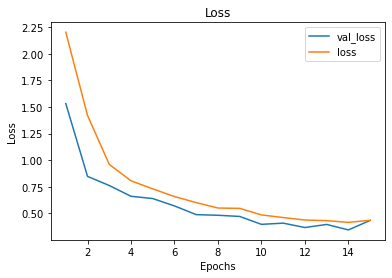

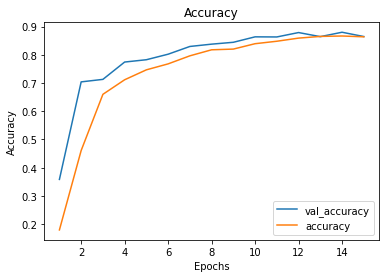

In [5]:
#Plot training and validation results of the augmented Vgg16 model
plt.figure()
plt.plot(Epochs, val_loss)
plt.plot(Epochs, loss)
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(Epochs, val_accuracy)
plt.plot(Epochs, accuracy)
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Predictions on entire test data
batch_size = 128
num_of_test_samples = 43
predictions = final_model.predict(aug16_test_generator,  num_of_test_samples // batch_size+1)
predictions

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 3803s 89s/step


array([[9.5655602e-01, 1.9834761e-08, 1.3393847e-07, ..., 2.5519415e-14,
        4.1826095e-02, 4.9745669e-11],
       [9.9076521e-01, 3.7083506e-10, 3.0588035e-05, ..., 7.3853694e-13,
        1.5919872e-03, 1.3579888e-12],
       [9.9691403e-01, 1.5065803e-08, 7.2683732e-04, ..., 2.2622876e-12,
        9.0733572e-04, 8.6473839e-10],
       ...,
       [1.3992223e-08, 5.3223107e-06, 5.1654124e-12, ..., 3.8503872e-22,
        1.4908080e-09, 9.9999464e-01],
       [1.8383040e-09, 5.9459802e-07, 6.4240585e-14, ..., 3.4354111e-25,
        6.8791230e-11, 9.9999940e-01],
       [5.9871834e-02, 3.2168701e-02, 7.0767677e-03, ..., 1.3612625e-06,
        7.2037955e-03, 8.2555550e-01]], dtype=float32)

In [ ]:
#Take our highest predicted class as our prediction
y_pred = np.argmax(predictions, axis=1)

#Define our X_test or Test Classes
true_classes = aug16_test_generator.classes

#Define our y_test or Test Labels
class_labels = list(aug16_test_generator.class_indices.keys())

#View a classification report to see how accurate our predicition were
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.87      0.91       600
              Forest       0.92      0.98      0.95       600
HerbaceousVegetation       0.87      0.83      0.85       600
             Highway       0.84      0.80      0.82       500
          Industrial       0.94      0.95      0.95       500
             Pasture       0.80      0.85      0.82       400
       PermanentCrop       0.88      0.79      0.83       500
         Residential       0.88      1.00      0.94       600
               River       0.76      0.79      0.77       500
             SeaLake       0.98      0.97      0.97       600

            accuracy                           0.89      5400
           macro avg       0.88      0.88      0.88      5400
        weighted avg       0.89      0.89      0.89      5400



Our results are promising with every class having above 85% on both precision and recall. It will be interesting to see if certain classes were commonly confused.

In [ ]:
#View our class names and indexes
aug16_test_generator.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
#Separate class names from indexes
cm_labels = list(aug16_test_generator.class_indices.keys())
cm_labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

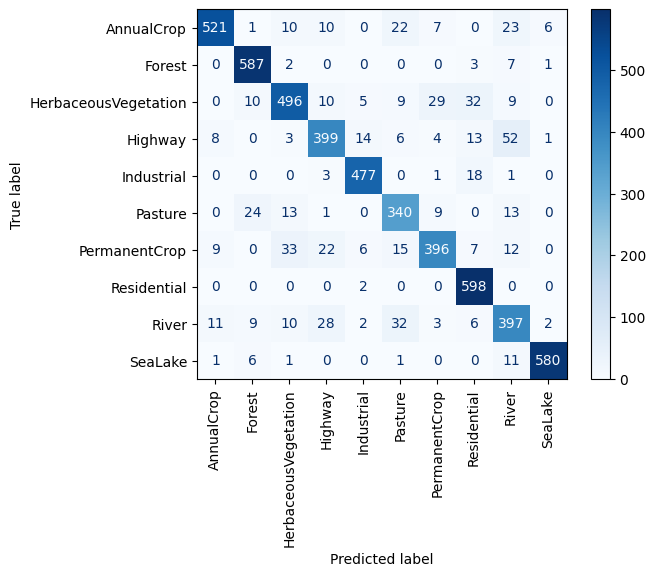

In [ ]:
#View confusion matrix of test predictions
final_disp = ConfusionMatrixDisplay.from_predictions(true_classes, y_pred,
                                                     display_labels=cm_labels,
                                                     xticks_rotation="vertical",
                                                     cmap=plt.cm.Blues)

As we saw in our classification report, the model did fairly well overall. From the confusion matrix, we can see there are some common misclassifications- Rivers for Highways (maybe due to their similar shape) and Pastures for Forests (maybe due to their abdundance of green). Improving differentiation between these classes will be a goal moving forward.